# Visualizing analyses with fresnel
In this notebook, we simulate a system of tetrahedra, color particles according to their local density, and path-trace the resulting image with [fresnel](https://github.com/glotzerlab/fresnel).

The cell below runs a short [HOOMD-blue](https://github.com/glotzerlab/hoomd-blue/) simulation of tetrahedra using Hard Particle Monte Carlo (HPMC).

In [1]:
import hoomd
import hoomd.hpmc

hoomd.context.initialize("")

# Create an 8x8x8 simple cubic lattice
system = hoomd.init.create_lattice(unitcell=hoomd.lattice.sc(a=1.5), n=8)

# Create our tetrahedra and configure the HPMC integrator
mc = hoomd.hpmc.integrate.convex_polyhedron(seed=42)
mc.set_params(d=0.2, a=0.1)
vertices = [(0.5, 0.5, 0.5), (-0.5, -0.5, 0.5), (-0.5, 0.5, -0.5), (0.5, -0.5, -0.5)]
mc.shape_param.set("A", vertices=vertices)

# Run for 5,000 steps
hoomd.run(5e3)
snap = system.take_snapshot()

HOOMD-blue v2.6.0-151-gea140cffb DOUBLE HPMC_MIXED MPI TBB SSE SSE2 SSE3 SSE4_1 SSE4_2 AVX AVX2 
Compiled: 09/25/2019
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
-----
You are using HPMC. Please cite the following:
* J A Anderson, M E Irrgang, and S C Glotzer. "Scalable Metropolis Monte Carlo
  for simulation of hard shapes", Computer Physics Communications 204 (2016) 21
  --30
-----
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 512 particles
** startin

Now we import the modules needed for analysis and visualization.

In [2]:
import fresnel
import freud
import matplotlib.cm
import numpy as np
from matplotlib.colors import Normalize

device = fresnel.Device()

Next, we'll set up the arrays needed for the scene and its geometry. This includes the analysis used for coloring particles.

In [3]:
poly_info = fresnel.util.convex_polyhedron_from_vertices(vertices)
positions = snap.particles.position
orientations = snap.particles.orientation
box = freud.Box.from_box(snap.box)
ld = freud.density.LocalDensity(3.0, 1.0)
ld.compute(system=snap)
colors = matplotlib.cm.viridis(Normalize()(ld.density))
box_points = np.asarray(
    [
        box.make_absolute(
            [
                [0, 0, 0],
                [0, 0, 0],
                [0, 0, 0],
                [1, 1, 0],
                [1, 1, 0],
                [1, 1, 0],
                [0, 1, 1],
                [0, 1, 1],
                [0, 1, 1],
                [1, 0, 1],
                [1, 0, 1],
                [1, 0, 1],
            ]
        ),
        box.make_absolute(
            [
                [1, 0, 0],
                [0, 1, 0],
                [0, 0, 1],
                [1, 0, 0],
                [0, 1, 0],
                [1, 1, 1],
                [1, 1, 1],
                [0, 1, 0],
                [0, 0, 1],
                [0, 0, 1],
                [1, 1, 1],
                [1, 0, 0],
            ]
        ),
    ]
)

This cell creates the scene and geometry objects to be rendered by `fresnel`.

In [4]:
scene = fresnel.Scene(device)
geometry = fresnel.geometry.ConvexPolyhedron(
    scene,
    poly_info,
    position=positions,
    orientation=orientations,
    color=fresnel.color.linear(colors),
)
geometry.material = fresnel.material.Material(
    color=fresnel.color.linear([0.25, 0.5, 0.9]), roughness=0.8, primitive_color_mix=1.0
)
geometry.outline_width = 0.05
box_geometry = fresnel.geometry.Cylinder(scene, points=box_points.swapaxes(0, 1))
box_geometry.radius[:] = 0.1
box_geometry.color[:] = np.tile([0, 0, 0], (12, 2, 1))
box_geometry.material.primitive_color_mix = 1.0
scene.camera = fresnel.camera.Orthographic.fit(scene, view="isometric", margin=0.1)

First, we preview the scene. (This doesn't use path tracing, and is much faster.)

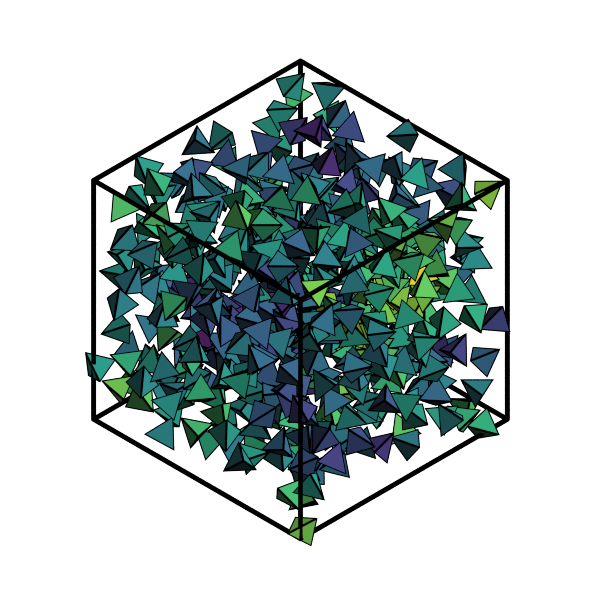

In [5]:
fresnel.preview(scene, anti_alias=True, w=600, h=600)

Finally, we use path tracing for a high quality image. The number of light samples can be increased to reduce path tracing noise.

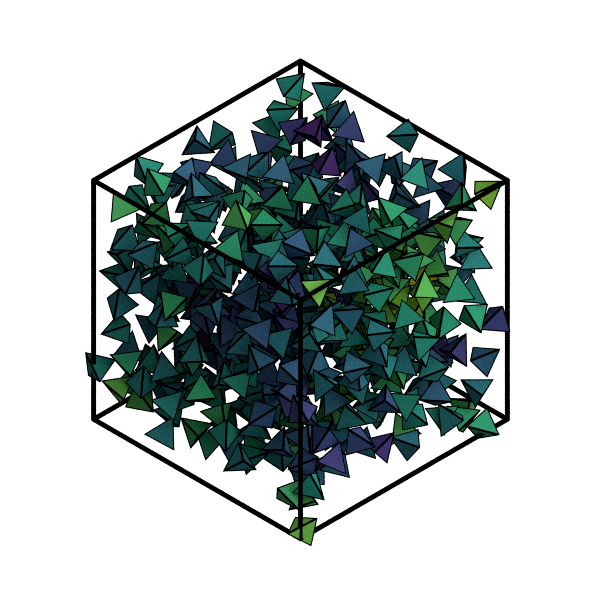

In [6]:
fresnel.pathtrace(scene, light_samples=16, w=600, h=600)